In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import h5py

%matplotlib notebook

paths = [
    r"C:\Users\Administrator\Code\qcodes_jens",
    r"C:\Users\Administrator\Code\pysweep2.0",
    r"C:\Users\Administrator\Code\pulsar",
]

for p in paths:
    if p not in sys.path:
        sys.path.append(p)

In [2]:
import qcodes as qc
from pysweep import sweep, Measurement

In [3]:
def create_inst(cls, name, *arg, **kw):
    force_new = kw.pop('force_new_instance', False)
    
    try:
        return cls(name, *arg, **kw)
    except KeyError:
        print("Instrument {} already exists.".format(name))
        if force_new:
            qc.Instrument._all_instruments[name]().close()
            return cls(name, *arg, **kw)
            
        return qc.Instrument._all_instruments[name]()

In [4]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = create_inst(AlazarTech_ATS9360, 'alazar')

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
RF = create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.2.20")
LO = create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.234.107")

from qcodes.instrument_drivers.rigol.DG4000 import Rigol_DG4000
fg = create_inst(Rigol_DG4000, 'fg', address="TCPIP0::169.254.190.44::inst0::INSTR")

station = qc.Station(alazar, ivvi, RF, LO, fg)

C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:182: UserWarning: Delay kwarg is deprecated. Replace with inter_delay or post_delay as needed
  warnings.warn("Delay kwarg is deprecated. Replace with "


Initialized IVVI-rack in 0.08s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.05s


In [5]:
station.ivvi.dac1.set_delay(0.001)
station.ivvi.dac1.set_step(20)
station.ivvi.dac6.set_delay(0.001)
station.ivvi.dac6.set_step(5)
station.ivvi.dac8.set_delay(0.001)
station.ivvi.dac8.set_step(5)
station.ivvi.dac11.set_delay(0.001)
station.ivvi.dac11.set_step(5)
station.ivvi.dac12.set_delay(0.001)
station.ivvi.dac12.set_step(5)

station.ivvi.set_dacs_zero()

station.fg.ch1_output_enabled(False)

C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:524: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "
C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:512: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "


In [6]:
from qcodes.instrument_drivers.AlazarTech.acq_controllers import ATS9360Controller
from qcodes.instrument_drivers.AlazarTech.acq_controllers.\
    alazar_channel import AlazarChannel

class BaseMeasurement(object):
    
    def __init__(self, station):
        self.station = station
        

        


class AlazarMeasurement(BaseMeasurement):
    
    controller_cls = ATS9360Controller
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.int_time = 0.1 # [s]
        self.int_delay = 1e-6 # [s]
        self.ifrq = 8e6
        
        self.nchans = 2
        self.sample_rate = int(1e9)
        self.trigger_source1 = 'CHANNEL_A'
        self.demod = False
        self.integrate_samples = False
        self.average_records = False
        self.average_buffers = True
        self.navgs = 1
        self.records_per_buffer = 1

        
    def setup_channels(self, **kw):
        self.chans = []
        for c in ['A', 'B']:
            _chan = AlazarChannel(self.station.alazar_ctl,
                                  'chan'+c, 
                                  demod=self.demod,
                                  integrate_samples=self.integrate_samples,
                                  average_records=self.average_records,
                                  average_buffers=self.average_buffers)
            self.station.alazar_ctl.channels.append(_chan)
            self.chans.append(_chan)
            
            if self.demod:
                _chan.demod_freq(self.ifrq)
                _chan.demod_type('IQ')
        
        self.station.alazar_ctl.int_time(self.int_time)
        self.station.alazar_ctl.int_delay(self.int_delay)
        print("Number of samples per record:", 
              self.station.alazar_ctl.samples_per_record())
        
        for c, n in zip(self.chans, ['A', 'B']):
            c.num_averages(self.navgs)
            if not self.average_records:
                c.records_per_buffer(self.records_per_buffer)
            c.alazar_channel(n)
            c.prepare_channel()
        
    
    def setup_alazar(self, **kw):
        if hasattr(self.station, 'alazar_ctl'):
            del station.components['alazar_ctl']

        _ctl = create_inst(self.controller_cls, 'alazar_ctl',
                           alazar_name='alazar', filter='ave', 
                           force_new_instance=True)
        self.station.add_component(_ctl)
        
        self.station.alazar.config(
              clock_source='INTERNAL_CLOCK',
              sample_rate=self.sample_rate,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1=self.trigger_source1, #'EXTERNAL',  # 'CHANNEL_A',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=128+2,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
              )

        self.setup_channels()
        

    def acquire(self):
        return self.station.alazar_ctl.channels.data()
           

In [ ]:
# m = AlazarMeasurement(station)
# m.sample_rate = int(1e8)
# m.int_time = 0.1

# m.setup_alazar()
# A, B = m.acquire()

# t = np.arange(A.size) * 1./m.sample_rate
# ffty = np.fft.rfft(A)
# fftx = np.fft.rfftfreq(A.size, d=1./m.sample_rate) * 1e-3 # [kHz]

# fig, ax = plt.subplots(1,1)
# ax.plot(fftx[1:], np.abs(ffty[1:])**2)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(1, None)


# fig, ax = plt.subplots(1,1)
# ax.plot(fftx[1:], np.abs(ffty[1:])**2)
# ax.set_yscale('log')
# ax.set_xlim(m.ifrq*1e-3 - 0.2, m.ifrq*1e-3 + 0.2)

In [7]:
import time
from collections import OrderedDict

Measurement.set_station(station)
Measurement.use_storage("np")

class RFSETMeasurement(AlazarMeasurement):
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.trigger_source1 = 'EXTERNAL'

    
    def _setup_run(self, station, namespace):
        station.RF.power(-35)
        station.LO.power(10)
        
    
    def _cleanup_run(self, station, namespace):
        station.RF.frequency(146.4e6)
        station.LO.frequency(146.4e6 + self.ifrq)
    
    
    def _msmt(self, station, namespace):
        f0 = station.RF.frequency()
        station.LO.frequency(f0 + self.ifrq)
        time.sleep(1e-3)
        f1 = station.LO.frequency()
        A, B = station.alazar_ctl.channels.data()
        
        return OrderedDict({
            "chanA_I" : {"unit" : "V", "value" : A.real},
            "chanA_Q" : {"unit" : "V", "value" : A.imag},
            "chanB_I" : {"unit" : "V", "value" : B.real},
            "chanB_Q" : {"unit" : "V", "value" : B.imag},
            "abs" : {"unit" : "V", "value" : (abs(A)**2 + abs(B)**2)**.5, },
        })
        

class SETResonanceScan(RFSETMeasurement):
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.integrate_samples = True
        self.demod = True
        self.average_records = True    

    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
                (sweep(self.station.RF.frequency, np.linspace(50e6, 200e6, 301)),
                 self._msmt)
            )
        return m.run()


In [ ]:
m = SETResonanceScan(station)
m.int_time = 50e-6
m.ifrq = 8e6
m.setup_alazar()
ret = m.run()

In [8]:
class SETBiasSweep(RFSETMeasurement):
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.integrate_samples = True
        self.demod = True
        self.average_records = True
        
    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
                (sweep(self.station.ivvi.dac1, np.linspace(-2000, 2000, 201)),
                 self._msmt)
            )
        return m.run()
        

# m = SETBiasSweep(station)
# m.int_time = 50e-6
# m.ifrq = 8e6
# m.setup_alazar()
# ret = m.run()

In [9]:
class TrigController(ATS9360Controller):
    fg = None
    
    def pre_acquire(self):
        time.sleep(1e-3)
        self.fg.ch1_output_enabled(True) 
        
    def post_acquire(self):
        self.fg.ch1_output_enabled(False)
        time.sleep(5e-3)
        return super().post_acquire()

In [16]:
class SETAWGGateSweep(RFSETMeasurement):
    
    controller_cls = TrigController
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.records_per_buffer = None
        self.integrate_samples = True
        self.demod = True
        self.average_records = False
        
    def _setup_run(self, station, namespace):
        station.fg.ch1_output_enabled(False)
    
    def _cleanup_run(self, station, namespace):
        station.fg.ch1_output_enabled(False)
        
    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
#                 (sweep(self.station.ivvi.dac1, [-200]), # np.linspace(-600, 1400, 101)),
                (sweep(self.station.ivvi.dac1, np.linspace(-600, 1400, 101)),
                 self._msmt)
            )
        return m.run()


fg.ch1_output_enabled(False)
station.fg.ch1_frequency(40)
TrigController.fg = station.fg

m = SETAWGGateSweep(station)
m.records_per_buffer = 200
m.int_time = 50e-6
m.navgs = 100
m.ifrq = 8e6
m.sample_rate = int(1e8)
m.setup_alazar()

ret = m.run()
fn = ret.data_prefix + r"_data.h5"
with h5py.File(fn, 'a') as f:
    f['data'] = ret.output()

Instrument alazar_ctl already exists.
Number of samples per record: 8192


C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:214: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '
C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


KeyboardInterrupt: 

In [17]:
class SETAWGGateSweep(RFSETMeasurement):
    
    controller_cls = TrigController
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.records_per_buffer = None
        self.integrate_samples = True
        self.demod = True
        self.average_records = False
        
    def _setup_run(self, station, namespace):
        station.fg.ch1_output_enabled(False)
    
    def _cleanup_run(self, station, namespace):
        station.fg.ch1_output_enabled(False)
        
    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
                (sweep(self.station.ivvi.dac1, [-200]), # np.linspace(-600, 1400, 101)),
#                 (sweep(self.station.ivvi.dac1, np.linspace(-600, 1400, 101)),
                 self._msmt)
            )
        return m.run()


fg.ch1_output_enabled(False)
station.fg.ch1_frequency(1)
TrigController.fg = station.fg

m = SETAWGGateSweep(station)
m.records_per_buffer = 200
m.int_time = 300e-6
m.navgs = 1
m.ifrq = 8e6
m.sample_rate = int(1e8)
m.setup_alazar()

ret = m.run()
fn = ret.data_prefix + r"_data.h5"
with h5py.File(fn, 'a') as f:
    f['data'] = ret.output()

Instrument alazar_ctl already exists.
Number of samples per record: 32768


C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:214: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '
C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


<IPython.core.display.Javascript object>


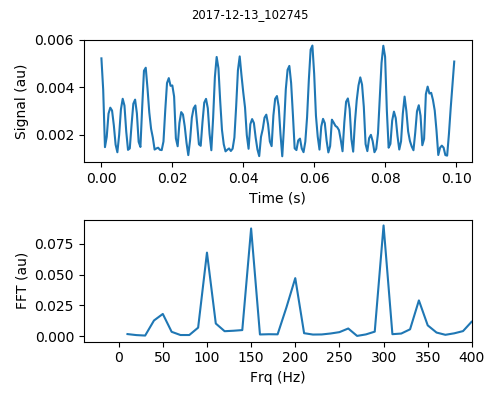

In [18]:
d = ret.output()
t = np.arange(m.records_per_buffer) * 0.5 * 1e-3 # [s]
y = d['abs'].reshape(-1)
# y /= y.max()

fig, (ax, bx) = plt.subplots(2,1, figsize=(5,4))

ax.plot(t, y)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal (au)")

ffty = abs(np.fft.rfft(y))[1:]
fftx = np.fft.rfftfreq(y.size, d=0.5 * 1e-3)[1:] # [Hz]
bx.plot(fftx, ffty)
bx.set_xlabel('Frq (Hz)')
bx.set_ylabel('FFT (au)')
bx.set_xlim(None, 400)

fig.tight_layout()
fig.suptitle(os.path.split(ret.data_prefix)[1], size='small')
fig.subplots_adjust(top=0.9)
fig.savefig(ret.data_prefix + r"_ttrace+fft.png")

In [ ]:
station.fg.ch1_frequency(10)
fg.ch1_output_enabled(True)

In [ ]:
fg.ch1_output_enabled(False)

In [109]:
ivvi.dac1(-220)

In [11]:
fg.reference_clock_source('external')

In [18]:
ivvi.set_dacs_zero()

In [24]:
fg.ch1_frequency()

40.0

In [25]:
station.alazar.sample_rate()

100000000